# Lesson 6 - Multi-LoRA


In this lesson, we'll see how to efficiently serve dozens of fine-tuned models together in a single deployment without sacrificing latency.

### Import required packages

In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn.functional as F
from tqdm import tqdm

### Let's create a new model

We will start with creating an extension to the model from lesson 5. It has a custom helper function for computing the LoRA layer step with multiple LoRAs per batch.

In [2]:
class AbstractMultiLoraModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # hidden_size = 10
        # set this so low to ensure we are not 
        # compute-bound by the linear layer
        # this is only an issue when running on CPU, 
        # for GPUs we can set this much
        # higher and still avoid being compute bound
        self.embedding = torch.nn.Embedding(10, 10)
        self.linear = torch.nn.Linear(10, 10)
        self.lm_head = torch.nn.Linear(10, 10)

    def linear_lora(
        self,
        x: torch.Tensor,                 # (batch_size, seq_len, in_features)
        loras_a: torch.Tensor,           # (num_loras, in_features, rank)
        loras_b: torch.Tensor,           # (num_loras, rank, out_features)
        lora_indices: torch.LongTensor,  # (batch_size,)
    ) -> torch.Tensor:
        # y[i] = x[i] @ loras_a[lora_idx] @ loras_b[lora_idx]
        raise NotImplementedError()

    def forward(self, input_ids, loras_a, loras_b, lora_indices):
        x = self.embedding(input_ids)
        x = self.linear_lora(x, loras_a, loras_b, lora_indices)
        x = self.lm_head(x)
        return x

### Using a loop

Our first attempt to infer across multiple LoRAs will be straightforward: just loop over every row in the batch and apply the correct LoRA using an index mapping: `batch_index --> lora_index`.

In [3]:
class LoopMultiLoraModel(AbstractMultiLoraModel):
    def linear_lora(
        self,
        x: torch.Tensor,                 # (batch_size, seq_len, in_features)
        loras_a: torch.Tensor,           # (num_loras, in_features, lora_rank)
        loras_b: torch.Tensor,           # (num_loras, lora_rank, out_features)
        lora_indices: torch.LongTensor,  # (batch_size,)
    ) -> torch.Tensor:
        y = self.linear(x)
        for batch_idx, lora_idx in enumerate(lora_indices.numpy()):
            lora_a = loras_a[lora_idx]
            lora_b = loras_b[lora_idx]
            y[batch_idx] += x[batch_idx] @ lora_a @ lora_b
        return y

In [4]:
# toy example of a detokenizer. The vocabular only consists of 10 words (different colors)
detokenizer = [
    "red",
    "orange",
    "yellow",
    "green",
    "blue",
    "indigo",
    "violet",
    "magenta",
    "marigold",
    "chartreuse",
]

In [5]:
# dummy inputs
input_ids = torch.LongTensor([[0, 1, 2, 3, 4, 5, 6, 7]])

In [6]:
torch.manual_seed(42)

In [7]:
def generate_token(model, **kwargs):
    with torch.no_grad():
        logits = model(**kwargs)
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)

    return [detokenizer[token_id] for token_id in next_token_ids]

In [8]:
model = LoopMultiLoraModel()

### Let's try it!

We will try this over a few random LoRAs using a fixed tensor of input_ids. If our multi-LoRA generation process is working as designed, we should see a variety of different outputs generated as we randomly iterate over the LoRAs.

In [9]:
# constants
bs = 1
num_loras = 64
h = 10
r = 2

# create contiguous blocks for 64 random LoRA weights
loras_a = torch.randn(num_loras, h, r)
loras_b = torch.randn(num_loras, r, h)

for i in range(10):
    # randomize the LoRAs each iteration
    lora_indices = torch.randint(num_loras, (bs,), dtype=torch.long)
    next_token = generate_token(
        model,
        input_ids=input_ids,
        loras_a=loras_a,
        loras_b=loras_b,
        lora_indices=lora_indices,
    )
    print(next_token)

['orange']
['red']
['chartreuse']
['yellow']
['marigold']
['yellow']
['red']
['orange']
['violet']
['red']


### Let's benchmark our multi-LoRA system!

We will measure the average latency to generate a single token as the batch size increases and each element within the batch can have a different LoRA adapter (chosen randomly).

In [10]:
# constants
seq_len = 8
vocab_size = 10
nsamples = 500
max_batch_size = 64


def benchmark(model):
    avg_latencies = []
    for bs in range(1, max_batch_size + 1):
        latencies = []
        for _ in range(nsamples):
            # randomize the inputs and LoRA indices
            input_ids = torch.randint(
                vocab_size, (bs, seq_len), dtype=torch.long)
            lora_indices = torch.randint(
                num_loras, (bs,), dtype=torch.long)

            # measure the end-to-end latency for 
            # generating a single token
            t0 = time.time()
            next_token = generate_token(
                model,
                input_ids=input_ids,
                loras_a=loras_a,
                loras_b=loras_b,
                lora_indices=lora_indices,
            )
            latencies.append(time.time() - t0)

        # average the latency across all the samples
        latency_s = sum(latencies) / len(latencies)
        avg_latencies.append(latency_s)
        print(bs, latency_s)
    return avg_latencies

**Note:** Your results might differ from those shown in the video, but they will still follow the same pattern.

In [11]:
avg_latencies_loop = benchmark(model)

1 3.852176666259766e-05
2 5.230283737182617e-05
3 6.096506118774414e-05
4 6.420516967773437e-05
5 7.079315185546875e-05
6 8.27188491821289e-05
7 8.885049819946289e-05
8 9.711933135986328e-05
9 0.00010551071166992187
10 0.00011343717575073243
11 0.000133270263671875
12 0.00013900279998779296
13 0.00013945484161376954
14 0.00014801979064941407
15 0.00016055250167846678
16 0.00016414737701416017
17 0.00017314577102661133
18 0.00018284225463867187
19 0.00018761968612670898
20 0.00019822454452514648
21 0.00020678615570068358
22 0.00021391820907592775
23 0.00024161243438720702
24 0.0002324385643005371
25 0.00024008607864379883
26 0.0002473936080932617
27 0.0002562861442565918
28 0.0002658123970031738
29 0.0002734689712524414
30 0.0002822599411010742
31 0.00031012582778930663
32 0.0002991976737976074
33 0.0003052563667297363
34 0.00031463861465454103
35 0.00032394599914550783
36 0.00033495616912841795
37 0.0003763875961303711
38 0.00034904909133911134
39 0.0003574132919311523
40 0.00036757993

### Let's visualize it!

**Note**: Your plot may vary slightly from the one shown in the video, yet it will exhibit a similar pattern.

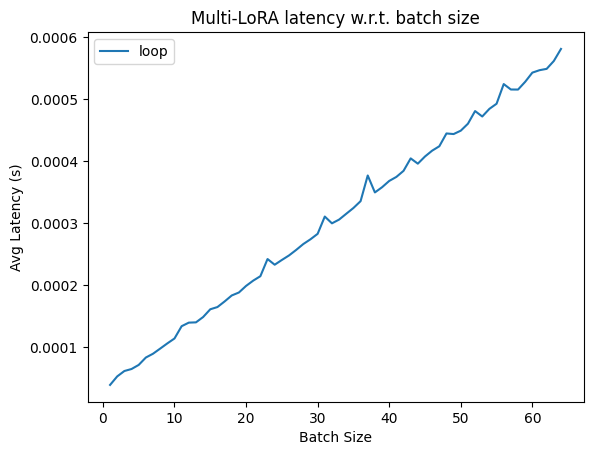

In [12]:
x = list(range(1, max_batch_size + 1))
plt.plot(x, avg_latencies_loop, label="loop")

plt.xlabel('Batch Size')
plt.ylabel('Avg Latency (s)')
plt.title('Multi-LoRA latency w.r.t. batch size')
plt.legend()

plt.show()

### Let's vectorize the LoRA computation

We will vectorize the LoRA computation by:

1. Gather the LoRA weight for each batch into a single tensor using `torch.index_select`.
2. Apply LoRA computation once for the entire input tensor.

In [13]:
class GatheredMultiLoraModel(AbstractMultiLoraModel):
    def linear_lora(
        self,
        x: torch.Tensor,                 # (batch_size, seq_len, in_features)
        loras_a: torch.Tensor,           # (num_loras, in_features, lora_rank)
        loras_b: torch.Tensor,           # (num_loras, lora_rank, out_features)
        lora_indices: torch.LongTensor,  # (batch_size,)
    ) -> torch.Tensor:
        y = self.linear(x)
        
        # gather the LoRA weights into a new tensor and apply
        lora_a = torch.index_select(loras_a, 0, lora_indices) # (batch_size, in_features, lora_rank)
        lora_b = torch.index_select(loras_b, 0, lora_indices) # (batch_size, lora_rank, out_features)
        y += x @ lora_a @ lora_b
        return y

In [14]:
model = GatheredMultiLoraModel()

**Note:** Your results might differ from those shown in the video, but they will still follow the same pattern.

In [15]:
avg_latencies_gathered = benchmark(model)

1 5.4540634155273435e-05
2 4.610633850097656e-05
3 4.7460556030273436e-05
4 4.7670841217041015e-05
5 4.887914657592774e-05
6 5.0412654876708984e-05
7 5.221319198608398e-05
8 5.306768417358398e-05
9 5.510044097900391e-05
10 5.566263198852539e-05
11 5.750513076782226e-05
12 5.800724029541016e-05
13 6.252861022949219e-05
14 5.9875011444091794e-05
15 6.124496459960937e-05
16 6.323909759521485e-05
17 6.467533111572265e-05
18 6.551313400268554e-05
19 6.589174270629883e-05
20 6.708335876464844e-05
21 6.814765930175781e-05
22 6.987762451171876e-05
23 7.089042663574219e-05
24 7.275152206420898e-05
25 7.884407043457032e-05
26 9.780645370483399e-05
27 7.644128799438476e-05
28 7.616329193115234e-05
29 7.78641700744629e-05
30 7.848548889160156e-05
31 8.045339584350587e-05
32 8.184957504272461e-05
33 8.295488357543945e-05
34 8.517074584960938e-05
35 8.597230911254883e-05
36 8.862781524658204e-05
37 8.801651000976563e-05
38 9.051847457885742e-05
39 8.993911743164063e-05
40 9.087610244750976e-05
41 9.

### Let's visualize it!

**Note**: Your plot may vary slightly from the one shown in the video, yet it will exhibit a similar pattern.

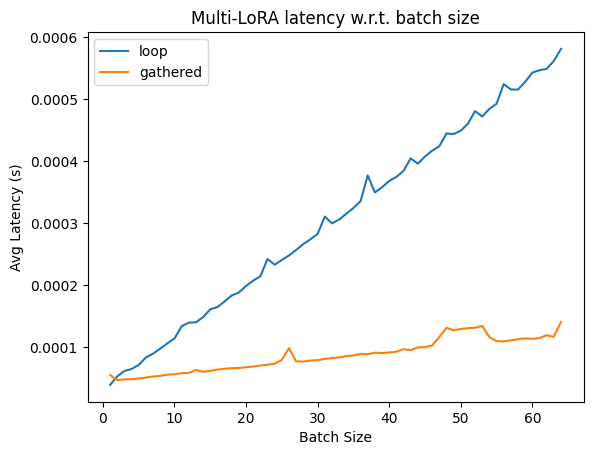

In [16]:
x = list(range(1, max_batch_size + 1))
plt.plot(x, avg_latencies_loop, label="loop")
plt.plot(x, avg_latencies_gathered, label="gathered")

plt.xlabel('Batch Size')
plt.ylabel('Avg Latency (s)')
plt.title('Multi-LoRA latency w.r.t. batch size')
plt.legend()

plt.show()